# Instructions on how to use this notebook: 


1. **Drag and drop your kaggle key into the /content directory. (IMPORTANT)**
2. Run all of the cells
3. In the end, you should end up with a frames.zip file, this contains the images that you'll use to train NeRF--

In [2]:
!mkdir ~/.kaggle
!mv kaggle.json ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [3]:
!kaggle datasets download -d newslab/cholecseg8k
!unzip cholecseg8k.zip

Streaming output truncated to the last 5000 lines.
  inflating: video48/video48_00561/frame_591_endo.png  
  inflating: video48/video48_00561/frame_591_endo_color_mask.png  
  inflating: video48/video48_00561/frame_591_endo_mask.png  
  inflating: video48/video48_00561/frame_591_endo_watershed_mask.png  
  inflating: video48/video48_00561/frame_592_endo.png  
  inflating: video48/video48_00561/frame_592_endo_color_mask.png  
  inflating: video48/video48_00561/frame_592_endo_mask.png  
  inflating: video48/video48_00561/frame_592_endo_watershed_mask.png  
  inflating: video48/video48_00561/frame_593_endo.png  
  inflating: video48/video48_00561/frame_593_endo_color_mask.png  
  inflating: video48/video48_00561/frame_593_endo_mask.png  
  inflating: video48/video48_00561/frame_593_endo_watershed_mask.png  
  inflating: video48/video48_00561/frame_594_endo.png  
  inflating: video48/video48_00561/frame_594_endo_color_mask.png  
  inflating: video48/video48_00561/frame_594_endo_mask.png  


In [4]:
# A simple PyTorch autoencoder to encode images in space.

import torch
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as T
from PIL import Image
import torch.nn as nn

In [5]:
import os, sys
import re
sys.path.append('../data/')

def sort_key(x):
    return int(re.sub('[^0-9]','', x))

class videoFrameDataset(Dataset):
    def __init__(self, dir, image_size):
        self.dir = dir
        self.imgs = [_ for _ in os.listdir(dir) if _.endswith("endo.png")] # List of image names in the directory
        self.imgs = sorted(self.imgs, key=sort_key)
        self.transform = T.Compose([
        T.Resize(image_size),
        T.ToTensor()])

    def __len__(self):
        return len(self.imgs)

    def get_path(self, idx):
        return self.dir +  "/" + self.imgs[idx]

    def __getitem__(self, idx):
        img = Image.open(self.dir + "/" + self.imgs[idx])
        return self.transform(img)

In [6]:
ds = videoFrameDataset("./video01/video01_00080/", (200, 200))

In [7]:
len(ds)

80

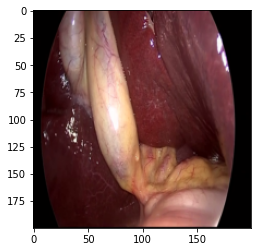

In [8]:
import matplotlib.pyplot as plt

plt.imshow(ds.__getitem__(0).permute(1, 2, 0))

In [9]:
class autoencoder(nn.Module):
    def __init__(self):
        super(autoencoder, self).__init__()
        # self.encoder = nn.Sequential(
        #     nn.Conv2d(3, 32, 2),
        #     nn.ReLU(),
        #     nn.MaxPool2d(2, stride=4),
        #     nn.Conv2d(32, 32, 4),
        #     nn.ReLU(),
        #     nn.MaxPool2d(2, stride=4),
        #     nn.Conv2d(32, 1, 2),
        #     nn.ReLU(),
        #     nn.MaxPool2d(2, stride=2),
        #     nn.Flatten(),
        #     nn.Linear(25, 25)
        # )
        # self.decoder = nn.Sequential(
        #     nn.Linear(25, 25),
        #     nn.Unflatten(1, (1, 5, 5)),
        #     nn.ConvTranspose2d(1, 32, 15),
        #     nn.ReLU(),
        #     nn.ConvTranspose2d(32, 32, 179),
        #     nn.ReLU(),
        #     nn.ConvTranspose2d(32, 3, 4),
        # )
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 8),
            nn.ReLU(),
            nn.MaxPool2d(4, stride=4),
            nn.Conv2d(32, 1, 8),
            nn.ReLU(),
            nn.MaxPool2d(4, stride=4),
            nn.Flatten(),
            nn.Linear(100, 20)
        )
        self.decoder = nn.Sequential(
            nn.Linear(20, 100),
            nn.Unflatten(1, (1, 10, 10)),
            nn.ConvTranspose2d(1, 32, 182),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, 10),
        )
        # self.encoder = nn.Sequential(
        #     nn.Flatten(),
        #     nn.Linear(120000, 240000),
        #     nn.ReLU(),
        #     nn.Linear(240000, 512000),
        #     nn.ReLU(),
        #     nn.Linear(512000, 50),
        # )
        # self.decoder = nn.Sequential(
        #     nn.Flatten(),
        #     nn.Linear(50, 512000),
        #     nn.ReLU(),
        #     nn.Linear(512000, 240000),
        #     nn.ReLU(),
        #     nn.Linear(240000, 120000),
        #     nn.Unflatten(1, (3, 200, 200))
        # )

    def forward(self, x):
        enc = self.encoder(x)
        dec = self.decoder(enc)
        return dec


In [10]:
from tqdm import tqdm
from torch.optim.lr_scheduler import ExponentialLR

device = (torch.device('cuda') if torch.cuda.is_available()
            else torch.device('cpu'))

network = autoencoder().to(device=device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(network.parameters(), lr=1e-3)
scheduler = ExponentialLR(optimizer, gamma=0.9)
dataloader = DataLoader(ds, batch_size=100, shuffle=True)

epochs = 10
for epoch in tqdm(range(epochs)):
    total_loss = 0
    print(f"Epoch: {epoch}")
    for img_batch in tqdm(dataloader):
        img_batch = img_batch.to(device=device)
        latent = network.encoder(img_batch)
        output = network.decoder(latent)
        # Add a sparsity term with some limit -- encourage variance to be 1 in the average
        if (l_term2 := torch.log(torch.mean(torch.var(network.encoder(img_batch), axis=0)))) > 0:
            l_term2 = 0
        loss = criterion(output, img_batch) - l_term2
        # print(img_batch)
        # print(network.encoder(img_batch))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.data
    print('epoch [{}/{}], loss:{:.4f}'
        .format(epoch+1, epochs, total_loss))

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0



 10%|█         | 1/10 [00:13<02:05, 13.92s/it]

epoch [1/10], loss:12.3986
Epoch: 1



 20%|██        | 2/10 [00:21<01:19,  9.96s/it]

epoch [2/10], loss:7.9776
Epoch: 2



 30%|███       | 3/10 [00:28<01:00,  8.63s/it]

epoch [3/10], loss:6.3488
Epoch: 3



 40%|████      | 4/10 [00:35<00:48,  8.03s/it]

epoch [4/10], loss:5.1683
Epoch: 4



 50%|█████     | 5/10 [00:42<00:38,  7.71s/it]

epoch [5/10], loss:4.2014
Epoch: 5



 60%|██████    | 6/10 [00:49<00:30,  7.54s/it]

epoch [6/10], loss:3.3812
Epoch: 6



 70%|███████   | 7/10 [00:56<00:22,  7.43s/it]

epoch [7/10], loss:2.7209
Epoch: 7



 80%|████████  | 8/10 [01:04<00:14,  7.37s/it]

epoch [8/10], loss:2.1007
Epoch: 8



 90%|█████████ | 9/10 [01:11<00:07,  7.34s/it]

epoch [9/10], loss:1.5265
Epoch: 9



100%|██████████| 10/10 [01:18<00:00,  7.87s/it]

epoch [10/10], loss:1.0311


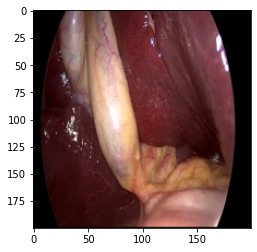

In [12]:
plt.imshow(ds.__getitem__(1).permute(1, 2, 0))

tensor([-2.4042, -1.8499,  1.9425, -5.2015, -3.3738,  1.3087, -0.5333, -5.1056,
         2.6481,  0.3551,  0.5572,  1.6128,  1.3082, -4.8533, -0.8609, -1.5796,
         2.2004,  0.6759, -2.1090,  0.7250])


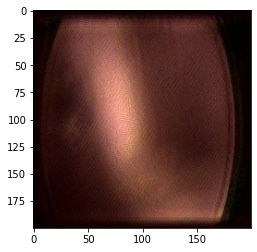

In [13]:
in_img = ds.__getitem__(1).unsqueeze(0).cuda()
plt.imshow(
    network(in_img).detach().cpu().squeeze().permute(1, 2, 0))
print(network.encoder(in_img).detach().cpu().squeeze())

In [14]:
# Plot frame locations in the latent space
import matplotlib
import numpy as np
latent_locs = []
colours = []
cmap = matplotlib.cm.get_cmap('Reds')

# prior_img = None
for i, img in tqdm(enumerate(ds)):
    # if i > 0:
    #     print((img == prior_img).all())
    #     prior_img = img
    # else:
    #     prior_img = img
    latent_locs.append(network.encoder(img.unsqueeze(0).cuda()).detach().cpu().numpy())
    colours.append(cmap(float(i) / len(ds)))

latent_locs = np.array(latent_locs).squeeze()
print(latent_locs)




80it [00:01, 52.23it/s]

[[-2.3995245  -1.8717629   1.9471508  ...  0.655358   -2.2032604
   0.67760044]
 [-2.4041986  -1.8498504   1.9425396  ...  0.67587286 -2.1090403
   0.725041  ]
 [-2.4176257  -1.8847147   1.9284354  ...  0.6875996  -2.076657
   0.7796796 ]
 ...
 [-4.5071635  -1.5916871  -0.06809309 ... -1.1812733  -2.2568033
   0.6466784 ]
 [-4.5113873  -1.6959288  -0.06995276 ... -1.1394465  -2.3091714
   0.6657229 ]
 [-4.5348344  -1.7931502  -0.09016612 ... -1.1679406  -2.3719375
   0.7225527 ]]


/usr/local/lib/python3.8/dist-packages/matplotlib/collections.py:885: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


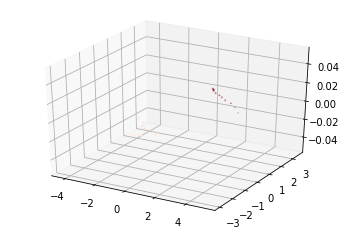

In [15]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3, random_state=0)
pca_obj = pca.fit_transform(latent_locs)

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

# plt.rcParams['figure.figsize'] = [8, 6]
plt.scatter(pca_obj[:,0], pca_obj[:,1], pca_obj[:,2], c=colours, marker="o")
plt.show()

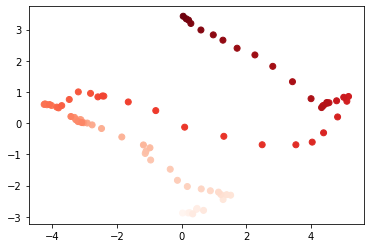

In [16]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2, random_state=0)
pca_obj = pca.fit_transform(latent_locs)

fig = plt.figure()
ax = fig.add_subplot()

plt.scatter(pca_obj[:,0], pca_obj[:,1], c=colours, marker="o")
plt.show()

In [ ]:
# Also try a known encoding scheme -- like a ResNet.
# Oh I'm running into the same silly problems that caused RN in the first place -- CNNs that can't learn the identity function. (ARGH!!)
# Maybe also try a VAE. Then there's ample to discuss in the writeup.

In [17]:
ref = latent_locs[0, :] # The image that we want to observe

In [18]:
distances = np.linalg.norm(latent_locs - ref, axis=-1)

In [19]:
distances

array([0.        , 0.21896131, 0.32762477, 0.5918714 , 0.5342437 ,
       0.50109327, 0.76792204, 1.5155705 , 1.8389164 , 1.7374843 ,
       1.5339792 , 1.565041  , 1.4012585 , 1.310029  , 1.2818155 ,
       1.4963166 , 1.8527803 , 2.4453073 , 2.7243454 , 2.791068  ,
       2.801105  , 2.8969812 , 3.4154742 , 3.9531915 , 4.201806  ,
       4.340125  , 4.5406003 , 4.562429  , 4.415783  , 4.5221195 ,
       4.696711  , 4.6156116 , 4.533677  , 4.435448  , 4.811549  ,
       5.495589  , 5.605913  , 5.676585  , 5.655424  , 5.536932  ,
       5.3152323 , 5.26589   , 5.243868  , 5.2692027 , 5.324431  ,
       5.081796  , 4.7549276 , 4.815464  , 4.7635946 , 4.307147  ,
       3.8383062 , 3.3076558 , 3.3431525 , 3.782833  , 4.524323  ,
       4.9793034 , 5.421079  , 6.0543604 , 6.588552  , 6.6696095 ,
       6.466329  , 6.143469  , 5.890449  , 5.69469   , 5.666735  ,
       5.842569  , 5.837368  , 5.615386  , 5.529644  , 5.5727854 ,
       5.631183  , 5.6693482 , 5.654122  , 5.7598543 , 5.84492

In [20]:
min_50_distances_idx = np.argpartition(distances, 51)

distances[min_50_distances_idx[:51]]

array([0.21896131, 3.782833  , 0.32762477, 0.5918714 , 0.5342437 ,
       0.50109327, 0.76792204, 1.5155705 , 1.8389164 , 1.7374843 ,
       1.5339792 , 1.565041  , 1.4012585 , 1.310029  , 1.2818155 ,
       1.4963166 , 1.8527803 , 2.4453073 , 2.7243454 , 2.791068  ,
       2.801105  , 2.8969812 , 3.4154742 , 3.9531915 , 4.201806  ,
       4.340125  , 0.        , 3.3431525 , 4.415783  , 4.5221195 ,
       3.3076558 , 3.8383062 , 4.307147  , 4.435448  , 4.524323  ,
       4.6156116 , 4.5406003 , 4.562429  , 4.9793034 , 4.811549  ,
       5.3152323 , 5.26589   , 5.243868  , 5.2692027 , 4.696711  ,
       5.081796  , 4.7549276 , 4.815464  , 4.7635946 , 4.533677  ,
       5.324431  ], dtype=float32)

In [21]:
# The indices
min_50_distances_idx[:51]

array([ 1, 53,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25,  0, 52, 28, 29, 51, 50, 49, 33,
       54, 31, 26, 27, 55, 34, 40, 41, 42, 43, 30, 45, 46, 47, 48, 32, 44])

In [28]:
SAVE_DIR = "frames"
if not os.path.exists(SAVE_DIR):
    os.mkdir(SAVE_DIR)

for img_idx in min_50_distances_idx[:51]:
    # Get path then copy it
    img_path = ds.get_path(img_idx)
    os.system(f"cp {img_path} {SAVE_DIR}")

In [33]:
!zip -r "$SAVE_DIR".zip "$SAVE_DIR"

  adding: frames/ (stored 0%)
  adding: frames/frame_107_endo.png (deflated 0%)
  adding: frames/frame_87_endo.png (deflated 0%)
  adding: frames/frame_110_endo.png (deflated 0%)
  adding: frames/frame_88_endo.png (deflated 0%)
  adding: frames/frame_81_endo.png (deflated 0%)
  adding: frames/frame_135_endo.png (deflated 0%)
  adding: frames/frame_102_endo.png (deflated 0%)
  adding: frames/frame_121_endo.png (deflated 0%)
  adding: frames/frame_103_endo.png (deflated 0%)
  adding: frames/frame_111_endo.png (deflated 0%)
  adding: frames/frame_122_endo.png (deflated 0%)
  adding: frames/frame_126_endo.png (deflated 0%)
  adding: frames/frame_134_endo.png (deflated 0%)
  adding: frames/frame_86_endo.png (deflated 0%)
  adding: frames/frame_83_endo.png (deflated 0%)
  adding: frames/frame_92_endo.png (deflated 0%)
  adding: frames/frame_96_endo.png (deflated 0%)
  adding: frames/frame_84_endo.png (deflated 0%)
  adding: frames/frame_80_endo.png (deflated 0%)
  adding: frames/frame_89_end